# Dogs vs Cats

# Задание 
Классификация изображений: Cats vs Dogs

Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. 


Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import zipfile
import os
from random import shuffle
import glob


print(tf.__version__)
print(tf.executing_eagerly())

2.8.0
True


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Функции загрузки данных


In [ ]:
train_dir = 'train'
test_dir = 'test'

with zipfile.ZipFile('/content/gdrive/MyDrive/Домашние работы /Компьютерное зрение/data/train.zip') as train_zip:
    train_zip.extractall('')
    
with zipfile.ZipFile('/content/gdrive/MyDrive/Домашние работы /Компьютерное зрение/data/test.zip') as test_zip:
    test_zip.extractall('')
train_files = glob.glob(os.path.join(train_dir,'*.jpg'))
test_files = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f"Train Data: {len(train_files)}")
print(f"Test Data: {len(test_files)}")

Train Data: 25000
Test Data: 12500


In [ ]:
IMG_SIZE = (224, 224)  # размер входного изображения сети


# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

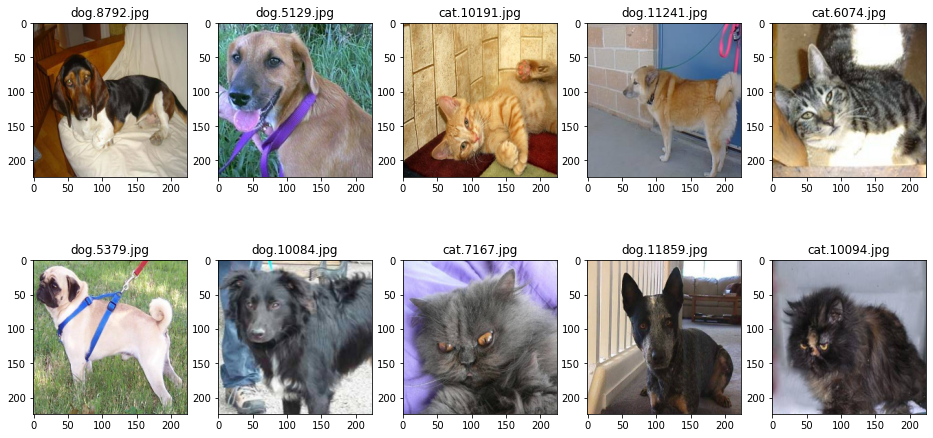

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [ ]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Моя сеть

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3,3),
                           padding='same',
                           activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                              padding='valid')(x)
x = tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=3, 
                           activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model= tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats_2')

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [ ]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 4s 386ms/step - loss: 0.6684 - accuracy: 0.6625 - val_loss: 3.6293 - val_accuracy: 0.6000
Epoch 2/100
10/10 [==============================] - 2s 206ms/step - loss: 0.3679 - accuracy: 0.8313 - val_loss: 1.7949 - val_accuracy: 0.6000
Epoch 3/100
10/10 [==============================] - 2s 202ms/step - loss: 0.2717 - accuracy: 0.8687 - val_loss: 0.2206 - val_accuracy: 0.8000
Epoch 4/100
10/10 [==============================] - 2s 210ms/step - loss: 0.2110 - accuracy: 0.9219 - val_loss: 0.4155 - val_accuracy: 0.6000
Epoch 5/100
10/10 [==============================] - 2s 207ms/step - loss: 0.1944 - accuracy: 0.9187 - val_loss: 0.0117 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 2s 208ms/step - loss: 0.2621 - accuracy: 0.8938 - val_loss: 0.0595 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 2s 207ms/step - loss: 0.1548 - accuracy: 0.9344 - val_loss: 0.0296 - val_accuracy: 1.0000

In [ ]:
model.summary()

Model: "dogs_vs_cats_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)    

In [ ]:
model.save('cats-dogs-vgg16.hdf5')

Предсказания на проверочной выборке

In [ ]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

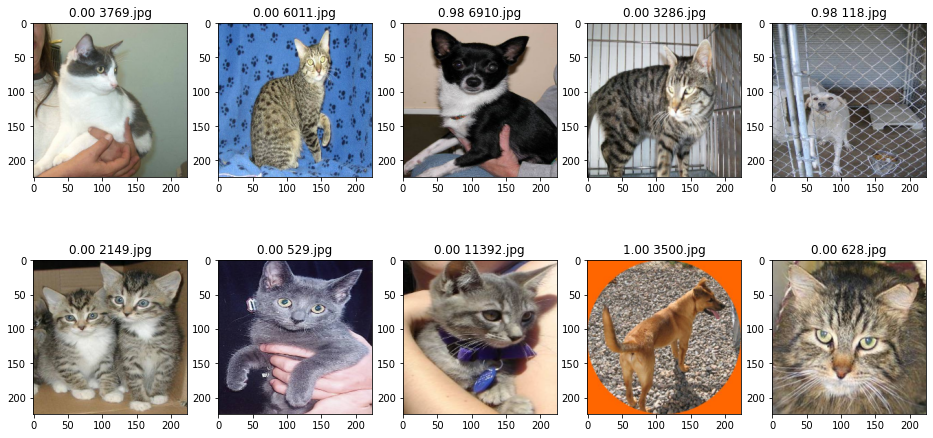

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [ ]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

Score:  0.13358

In [ ]:
test_pred.shape

(12500, 1)

In [ ]:
len(test_files)

12500